# QLoRA Fine-tuning for RTX 3080
## Mistral-7B 모델을 RTX 3080에서 효율적으로 학습하기

### 1. 필요한 라이브러리 임포트

In [6]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    TrainerCallback,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
import time

print("✓ 라이브러리 임포트 완료")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 버전: {torch.version.cuda}")

✓ 라이브러리 임포트 완료
PyTorch 버전: 2.5.1+cu121
CUDA 사용 가능: True
GPU: NVIDIA GeForce RTX 3080
CUDA 버전: 12.1


### 2. 모델 ID 및 토크나이저 설정

In [7]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# Mistral은 pad_token이 없으므로, eos_token을 pad_token으로 설정
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✓ 토크나이저 로드 완료")
print(f"모델: {model_id}")
print(f"Vocabulary 크기: {len(tokenizer)}")

✓ 토크나이저 로드 완료
모델: mistralai/Mistral-7B-v0.1
Vocabulary 크기: 32000


### 3. QLoRA 설정 (BitsAndBytesConfig)

In [8]:
# RTX 3080을 위한 핵심 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # 4비트 양자화 활성화
    bnb_4bit_quant_type="nf4",              # 4비트 NormalFloat 사용
    bnb_4bit_compute_dtype=torch.bfloat16,  # 계산은 bfloat16으로 수행 (3080 지원)
    bnb_4bit_use_double_quant=True,         # 이중 양자화로 메모리 추가 절약
)

print("✓ QLoRA 설정 완료")
print("  - 4비트 양자화: 활성화")
print("  - 양자화 타입: NF4")
print("  - 계산 타입: bfloat16")
print("  - 이중 양자화: 활성화")

✓ QLoRA 설정 완료
  - 4비트 양자화: 활성화
  - 양자화 타입: NF4
  - 계산 타입: bfloat16
  - 이중 양자화: 활성화


### 4. 모델 로드 (4비트 양자화)

In [9]:
print("모델 로딩 중... (시간이 걸릴 수 있습니다)")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"  # GPU에 자동으로 모델 배치
)

print("✓ 모델 로드 완료")
print(f"모델 타입: {type(model).__name__}")
print(f"디바이스: {next(model.parameters()).device}")

모델 로딩 중... (시간이 걸릴 수 있습니다)


Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


✓ 모델 로드 완료
모델 타입: MistralForCausalLM
디바이스: cuda:0


### 5. LoRA 설정 (PEFT)

In [10]:
# 랭크(r)를 낮춰(예: 8) VRAM을 더 절약할 수 있습니다.
peft_config = LoraConfig(
    r=8,                            # LoRA 랭크 (더 낮추면 VRAM 절약)
    lora_alpha=16,                  # 알파 (보통 r * 2)
    target_modules=[                # Mistral-7B의 대상 모듈
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

print("✓ LoRA 설정 완료")
print(f"  - 랭크(r): {peft_config.r}")
print(f"  - 알파: {peft_config.lora_alpha}")
print(f"  - 드롭아웃: {peft_config.lora_dropout}")
print(f"  - 대상 모듈 수: {len(peft_config.target_modules)}")

✓ LoRA 설정 완료
  - 랭크(r): 8
  - 알파: 16
  - 드롭아웃: 0.05
  - 대상 모듈 수: 7


### 6. PEFT 모델 준비

In [11]:
# k-bit 학습을 위해 모델 준비 (그래디언트 체크포인팅 활성화)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# 학습 가능한 파라미터 확인
print("\n학습 가능한 파라미터:")
model.print_trainable_parameters()

# GPU 메모리 사용량 확인
if torch.cuda.is_available():
    print(f"\nGPU 메모리 할당: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU 메모리 예약: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


학습 가능한 파라미터:
trainable params: 20,971,520 || all params: 7,262,703,616 || trainable%: 0.2888

GPU 메모리 할당: 7.77 GB
GPU 메모리 예약: 8.49 GB


### 7. 데이터셋 로드 및 전처리

In [12]:
# RTX 3080에서 빠르게 테스트하기 위해 1000개 샘플만 사용
print("데이터셋 로딩 중...")
data = load_dataset("databricks/databricks-dolly-15k", split="train").shuffle()

print(f"✓ 데이터셋 로드 완료")
print(f"  - 샘플 수: {len(data)}")
print(f"  - 컬럼: {data.column_names}")

# 샘플 데이터 미리보기
print("\n[샘플 데이터]")
print(f"Instruction: {data[0]['instruction'][:100]}...")
print(f"Response: {data[0]['response'][:100]}...")

데이터셋 로딩 중...
✓ 데이터셋 로드 완료
  - 샘플 수: 15011
  - 컬럼: ['instruction', 'context', 'response', 'category']

[샘플 데이터]
Instruction: From this paragraph please summarize the notable California regions where pinot noir is produced....
Response: Notable California regions that produce pinot noir include Sonoma County (Russian River Valley and S...


In [13]:
# 프롬프트 형식화 함수
def format_instruction(sample):
    return f"""### Instruction:
{sample['instruction']}

### Context:
{sample['context']}

### Response:
{sample['response']}
"""

# 토크나이저 적용
print("토크나이징 중...")
tokenized_data = data.map(
    lambda p: tokenizer(format_instruction(p), truncation=True, max_length=512, padding="max_length"),
    remove_columns=data.column_names
)

print("✓ 토크나이징 완료")
print(f"  - 최대 길이: 512 토큰")
print(f"  - 샘플 shape: {tokenized_data[0]['input_ids'].shape if hasattr(tokenized_data[0]['input_ids'], 'shape') else len(tokenized_data[0]['input_ids'])}")

토크나이징 중...


Map: 100%|██████████| 15011/15011 [00:06<00:00, 2369.00 examples/s]

✓ 토크나이징 완료
  - 최대 길이: 512 토큰
  - 샘플 shape: 512


### 8. 학습 시각화를 위한 커스텀 콜백 정의

In [14]:
class VisualizationCallback(TrainerCallback):
    """학습 과정을 실시간으로 시각화하는 콜백"""
    
    def __init__(self):
        self.losses = []
        self.steps = []
        self.start_time = None
        self.fig, self.axes = plt.subplots(1, 2, figsize=(15, 5))
        
    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()
        print("🚀 학습 시작!\n")
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])
            self.steps.append(state.global_step)
            
            # 그래프 업데이트
            self.update_plots(state, logs)
            
    def update_plots(self, state, logs):
        clear_output(wait=True)
        
        # Loss 그래프
        self.axes[0].clear()
        self.axes[0].plot(self.steps, self.losses, 'b-', linewidth=2, label='Training Loss')
        self.axes[0].set_xlabel('Steps', fontsize=12)
        self.axes[0].set_ylabel('Loss', fontsize=12)
        self.axes[0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
        self.axes[0].grid(True, alpha=0.3)
        self.axes[0].legend()
        
        # 진행률 및 통계
        self.axes[1].clear()
        self.axes[1].axis('off')
        
        elapsed_time = time.time() - self.start_time
        progress = (state.global_step / state.max_steps) * 100 if state.max_steps > 0 else 0
        
        stats_text = f"""
        Training Statistics
        ========================================
        
        Step: {state.global_step} / {state.max_steps}
        Progress: {progress:.1f}%
        
        Current Loss: {logs.get('loss', 0):.4f}
        Average Loss: {np.mean(self.losses) if self.losses else 0:.4f}
        Min Loss: {min(self.losses) if self.losses else 0:.4f}
        
        Elapsed Time: {elapsed_time/60:.1f} min
        Learning Rate: {logs.get('learning_rate', 0):.2e}
        
        Epoch: {logs.get('epoch', 0):.2f}
        """
        
        if torch.cuda.is_available():
            gpu_mem = torch.cuda.memory_allocated() / 1024**3
            stats_text += f"\n        GPU Memory: {gpu_mem:.2f} GB"
        
        self.axes[1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                         verticalalignment='center')
        
        plt.tight_layout()
        display(self.fig)
        
    def on_train_end(self, args, state, control, **kwargs):
        total_time = time.time() - self.start_time
        print(f"\n\n✅ 학습 완료!")
        print(f"총 소요 시간: {total_time/60:.1f}분")
        print(f"최종 Loss: {self.losses[-1] if self.losses else 'N/A'}")
        print(f"최소 Loss: {min(self.losses) if self.losses else 'N/A'}")

print("✓ 시각화 콜백 정의 완료")

✓ 시각화 콜백 정의 완료


### 9. TrainingArguments 설정

In [15]:
# RTX 3080을 위한 핵심 설정
training_args = TrainingArguments(
    output_dir="./qlora-mistral-3080",
    per_device_train_batch_size=1,   # 배치 크기를 1로 설정 (VRAM 한계)
    gradient_accumulation_steps=16,   # 1 * 16 = 실질적 배치 크기 16
    
    optim="paged_adamw_32bit",       # 32비트가 8비트보다 안정적일 수 있음
    
    learning_rate=2e-4,              # QLoRA 권장 학습률
    lr_scheduler_type="cosine",      # 코사인 학습률 스케줄러
    num_train_epochs=5,              # 예제이므로 5 에포크
    
    fp16=True,                       # 3080은 fp16이 더 안정적
    
    logging_steps=10,
    save_strategy="epoch",
    
    gradient_checkpointing=True,     # VRAM을 크게 절약 (속도는 느려짐)
)

print("✓ Training Arguments 설정 완료")
print(f"  - 배치 크기: {training_args.per_device_train_batch_size}")
print(f"  - Gradient Accumulation: {training_args.gradient_accumulation_steps}")
print(f"  - 실질 배치 크기: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  - 학습률: {training_args.learning_rate}")
print(f"  - 스케줄러 타입: {training_args.lr_scheduler_type}")
print(f"  - 에포크: {training_args.num_train_epochs}")
print(f"  - FP16: {training_args.fp16}")

✓ Training Arguments 설정 완료
  - 배치 크기: 1
  - Gradient Accumulation: 16
  - 실질 배치 크기: 16
  - 학습률: 0.0002
  - 스케줄러 타입: cosine
  - 에포크: 5
  - FP16: True


### 10. Trainer 초기화

✓ Trainer 초기화 완료
  - 시각화 콜백이 추가되었습니다.


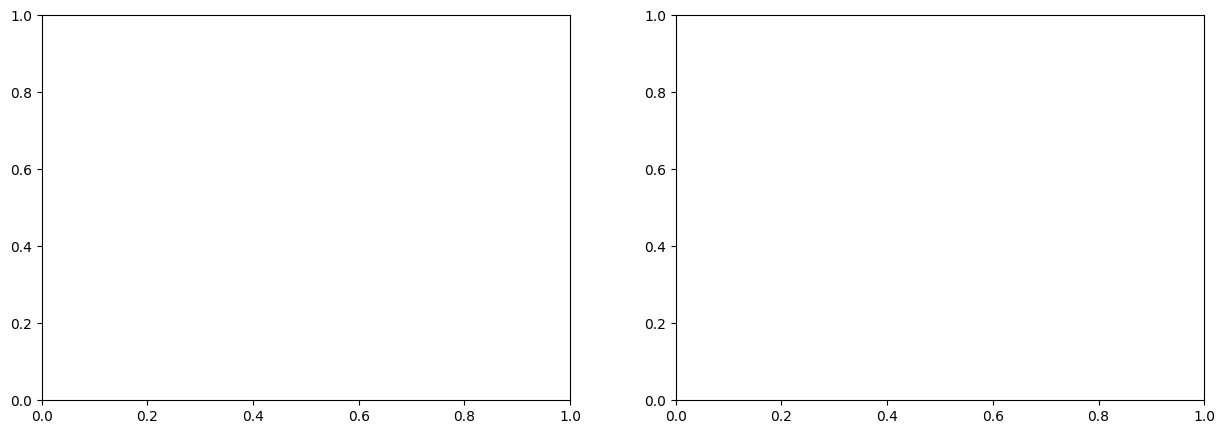

In [16]:
# 데이터 콜레이터 정의
def data_collator(data):
    return {
        'input_ids': torch.stack([torch.tensor(f['input_ids']) for f in data]),
        'attention_mask': torch.stack([torch.tensor(f['attention_mask']) for f in data]),
        'labels': torch.stack([torch.tensor(f['input_ids']) for f in data])  # Causal LM은 labels=input_ids
    }

# 시각화 콜백 인스턴스 생성
viz_callback = VisualizationCallback()

# Trainer 초기화
trainer = Trainer(
    model=model,
    train_dataset=tokenized_data,
    args=training_args,
    data_collator=data_collator,
    callbacks=[viz_callback]  # 시각화 콜백 추가
)

print("✓ Trainer 초기화 완료")
print("  - 시각화 콜백이 추가되었습니다.")

### 11. 학습 시작 🚀

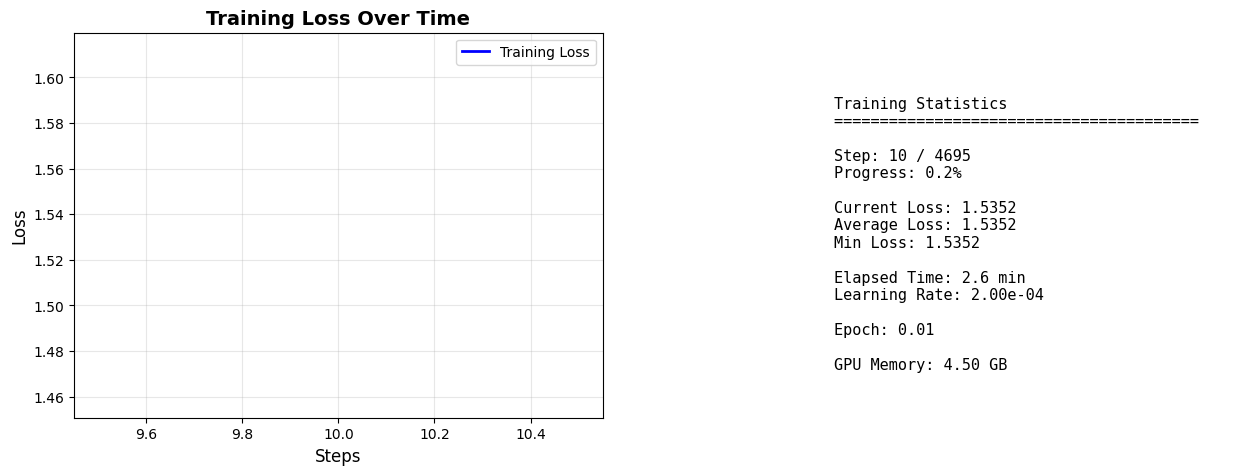

In [ ]:
print("="*50)
print("RTX 3080 최적화 QLoRA 학습 시작...")
print("="*50)
print()

# 학습 시작 (시각화가 자동으로 표시됩니다)
trainer.train()

### 12. 모델 저장

In [13]:
print("\n학습 완료. 모델 저장 중...")

output_dir = "./qlora-mistral-3080-final"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✓ 모델 저장 완료: {output_dir}")
print("\n🎉 모든 작업이 완료되었습니다!")


학습 완료. 모델 저장 중...
✓ 모델 저장 완료: ./qlora-mistral-3080-final

🎉 모든 작업이 완료되었습니다!


### 13. 최종 학습 결과 요약


📊 최종 학습 결과 요약
총 Step 수: 25
시작 Loss: 1.6375
최종 Loss: 0.4306
최소 Loss: 0.3866
평균 Loss: 0.5583
Loss 감소율: 73.70%


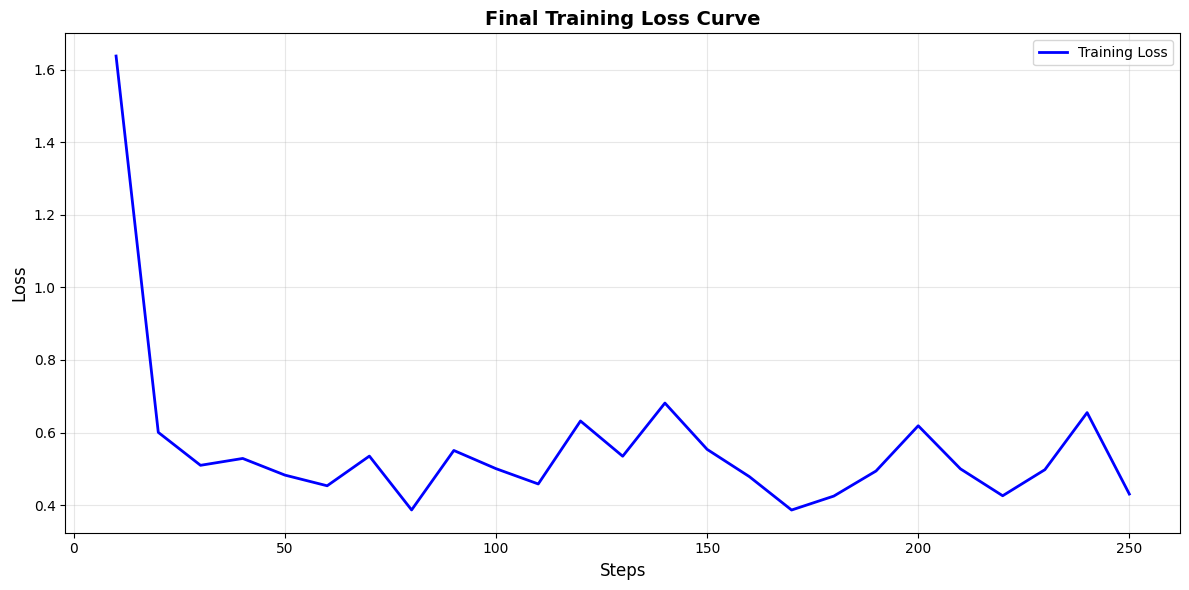


✓ 학습 곡선이 './qlora-mistral-3080-final/training_loss.png'에 저장되었습니다.


In [14]:
# 최종 통계 출력
if viz_callback.losses:
    print("\n" + "="*50)
    print("📊 최종 학습 결과 요약")
    print("="*50)
    print(f"총 Step 수: {len(viz_callback.steps)}")
    print(f"시작 Loss: {viz_callback.losses[0]:.4f}")
    print(f"최종 Loss: {viz_callback.losses[-1]:.4f}")
    print(f"최소 Loss: {min(viz_callback.losses):.4f}")
    print(f"평균 Loss: {np.mean(viz_callback.losses):.4f}")
    print(f"Loss 감소율: {((viz_callback.losses[0] - viz_callback.losses[-1]) / viz_callback.losses[0] * 100):.2f}%")
    print("="*50)
    
    # 최종 Loss 그래프
    plt.figure(figsize=(12, 6))
    plt.plot(viz_callback.steps, viz_callback.losses, 'b-', linewidth=2, label='Training Loss')
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Final Training Loss Curve', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('./qlora-mistral-3080-final/training_loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 학습 곡선이 './qlora-mistral-3080-final/training_loss.png'에 저장되었습니다.")
else:
    print("학습 데이터가 기록되지 않았습니다.")

### 14. GPU 메모리 정리

In [15]:
# GPU 메모리 정리
import gc

if torch.cuda.is_available():
    print("GPU 메모리 정리 중...")
    torch.cuda.empty_cache()
    gc.collect()
    print(f"✓ GPU 메모리 정리 완료")
    print(f"현재 GPU 메모리 사용량: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

GPU 메모리 정리 중...
✓ GPU 메모리 정리 완료
현재 GPU 메모리 사용량: 4.50 GB
